## Neuroevolution using EvoTorch

#### Imports

In [1]:
import torch
import numpy as np
import math

from evotorch.tools import dtype_of, device_of
from evotorch.neuroevolution import NEProblem
from evotorch.algorithms import PGPE
from evotorch.logging import PandasLogger, StdOutLogger

from Trainer import Trainer
from Model import Complex_CA
from State_Generator import Generator, State
!jt -t onedork

zsh:1: command not found: jt


In [2]:
#hw = 'mps:0' if torch.backends.mps.is_available() else 'cpu'
#hw = 'cuda'
hw = 'cpu'
device = torch.device(hw)
batch_size = 16
generator = Generator(False)
device

device(type='cpu')

#### Helper functions

In [3]:
batch = generator.generate_ca_and_food(batch_size)

In [4]:
def average_placement(x):
    #TODO what happens in case the total value of the CA is negative? - Only the case when the model suchs but still the case
    size = x.shape[0]
    d1 = 0
    d2 = 0
    total = x.sum() / size
    if total <= 0:
        return(17, 17)
    
    def to_int(x):
        if math.isnan(x):
            return 0
        else:
            return int(x)

    for i in range(size):
        d1 += x[i].mean() * i / total
        d2 += x[:, i].mean() * i / total
    return (to_int(d1), to_int(d2))

#### Network

In [5]:
#TODO load one of the good existing models and train from here?

#### Actor - For sharing batch between all rays

In [6]:
import ray

@ray.remote
class GlobalVarActor:
    def __init__(self):
        self.batch = generator.generate_ca_and_food(batch_size)

    def set_global_var(self):
        self.batch = generator.generate_ca_and_food(batch_size)

    def get_global_var(self):
        return self.batch

global_var = GlobalVarActor.remote()
ray.get(global_var.set_global_var.remote())
print(ray.get(global_var.get_global_var.remote()).sum())

2022-11-30 12:12:50,415	INFO worker.py:1528 -- Started a local Ray instance.


224.0


#### Fitness function

In [7]:
#test
batch = generator.generate_ca_and_food(batch_size)
batch = torch.tensor(batch, device=device)
cell = batch
food = batch[:, 3]
#food_pos = np.apply_along_axis(average_placement, 1, food)
food_pos = np.ones(shape=(17,2))
average_cell_pos = np.ones(shape=(17,2))
for i, x in enumerate(food):
    food_pos[i] = average_placement(x)
for i, x in enumerate(cell[:, 0]):
    average_cell_pos[i] = average_placement(x)
distance = ((food_pos - average_cell_pos) ** 2).sum()/100
print(distance)

2.13


In [32]:
class Custom_NE(NEProblem):
    #def __init__(self, objective_sense, network, network_args, device, num_actors, searcher):
    #    super(Custom_NE, self).__init__(objective_sense=objective_sense, network=network, network_args=network_args, device=device, num_actors=num_actors)

    #@property
    #def _network_constants(self):
    #    return {"batch": self.batch}

    def _evaluate_network(self, network: torch.nn.Module):
        #We need some way of ensuring each new batch is the same for each network in the same generation - otherwise we optimize on luck rather than skill
        batch = ray.get(global_var.get_global_var.remote())
        cell = torch.tensor(batch, dtype=dtype_of(network), device=device_of(network))
        cell = cell
        food = cell[:, 3]

        total_pixel_val_before = network.total_pixel_val(cell[:, 0:1])    
        living_count_before = network.living_cells_above(cell[:, 0:1], 0.1)
        food_pos = np.ones(shape=(17,2))
        for i, x in enumerate(food):
            food_pos[i] = average_placement(x)
        #print(food_pos[0])

        steps = 15

        #apply model
        cell, food, total_pixel_val, living_count = network(cell, food, steps)
        
        total_pixel_diff = ((total_pixel_val_before - total_pixel_val) ** 2).sum()
        living_count_diff = ((living_count_before - living_count) ** 2).sum()
        average_cell_pos = np.ones(shape=(17,2))
        for i, x in enumerate(cell[:, 0]):
            average_cell_pos[i] = average_placement(x)
        distance = ((food_pos-average_cell_pos) ** 2).sum()

        fitness = total_pixel_diff/3 + living_count_diff/100 + distance
        return fitness

#### Creating problem

In [33]:
problem = Custom_NE(
    objective_sense="min",
    network=Complex_CA,
    network_args={"device":device, "batch_size":batch_size},
    #network_eval_func=score,
    device="cpu",
    num_actors='max',
)

#### Searcher algorithm

In [34]:
from functools import partial

class Custom_Searcher(PGPE):
    def __init__(self, problem, *, popsize, center_learning_rate, stdev_learning_rate, stdev_init=None, radius_init=None, num_interactions=None, popsize_max=None, optimizer='clipup', optimizer_config=None, ranking_method='centered', center_init=None, stdev_min=None, stdev_max=None, stdev_max_change=0.2, symmetric=True, obj_index=None, distributed=False, popsize_weighted_grad_avg=None):
        super(Custom_Searcher, self).__init__(problem, popsize=popsize, center_learning_rate=center_learning_rate, stdev_learning_rate=stdev_learning_rate, stdev_init=stdev_init, radius_init=radius_init, num_interactions=num_interactions, popsize_max=popsize_max, optimizer=optimizer, optimizer_config=optimizer_config, ranking_method=ranking_method, center_init=center_init, stdev_min=stdev_min, stdev_max=stdev_max, stdev_max_change=stdev_max_change, symmetric=symmetric, obj_index=obj_index, distributed=distributed, popsize_weighted_grad_avg=popsize_weighted_grad_avg)
    
    def before(self):
        #print(self.step_count)
        ray.get(global_var.set_global_var.remote())

In [35]:
searcher = Custom_Searcher(
    problem,
    popsize=1000,
    radius_init=0.5,
    center_learning_rate=0.0005,
    stdev_learning_rate=0.0002,
)

searcher.before_step_hook.append(searcher.before)

#### Logger and run

In [36]:
logger = StdOutLogger(searcher)
logger = PandasLogger(searcher)
searcher.run(200)

0
         iter : 1
    mean_eval : 1673.9820556640625
pop_best_eval : 112.03128814697266
  median_eval : 404.8658142089844
    best_eval : 112.03128814697266
   worst_eval : 122451.5625

1
         iter : 2
    mean_eval : 1630.3070068359375
pop_best_eval : 100.1703872680664
  median_eval : 384.961181640625
    best_eval : 100.1703872680664
   worst_eval : 122451.5625

2
         iter : 3
    mean_eval : 1904.4326171875
pop_best_eval : 98.43136596679688
  median_eval : 400.7510986328125
    best_eval : 98.43136596679688
   worst_eval : 144119.234375

3
         iter : 4
    mean_eval : 1517.38720703125
pop_best_eval : 127.48477172851562
  median_eval : 414.3381042480469
    best_eval : 98.43136596679688
   worst_eval : 144119.234375

4
         iter : 5
    mean_eval : 3050.791259765625
pop_best_eval : 112.53242492675781
  median_eval : 442.19964599609375
    best_eval : 98.43136596679688
   worst_eval : 1431234.0

5
         iter : 6
    mean_eval : 1805.4844970703125
pop_best_eval :

#### Show learning curve

<AxesSubplot:xlabel='iter'>

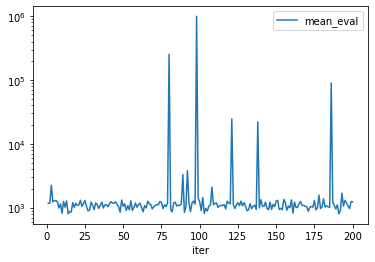

In [24]:
#TODO find a way of showing this in logarithmic scale
#logger.to_dataframe().mean_eval.plot(Log=True)
#logger.to_dataframe().mean_eval.plot()
#x = logger.to_dataframe().mean_eval
#logger.to_dataframe().mean_eval.plot(log=True)
logger.to_dataframe().plot(y='mean_eval', logy=True)

<AxesSubplot:xlabel='iter'>

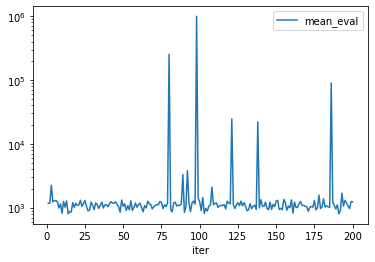

In [25]:
logger.to_dataframe().plot(y='mean_eval', logy=True)

<AxesSubplot:xlabel='iter'>

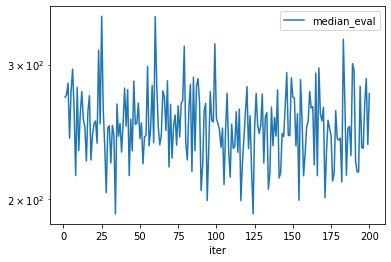

In [26]:
logger.to_dataframe().plot(y='median_eval', logy=True)

#### Get Network with parameters according to trained model

In [27]:
trained_network = problem.parameterize_net(searcher.status['center'])
#save model
torch.save(trained_network.state_dict(), 'models/evo3.pth')

#### Use Model

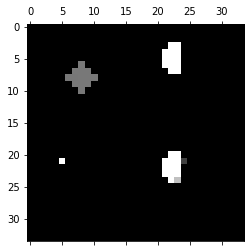

In [28]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, HTML
import IPython

#TODO
state = generator.generate_moving_state(50, batch_size)

def extract_data(cell, target):
    row1 = np.hstack((cell[0, 0].detach().cpu().numpy(), target[0]))
    row2 = np.hstack((state.food[0], state.y[0]))
    return np.vstack((row1, row2))

@torch.no_grad()
def animate(i):
    global cell
    global target
    global food
    global food_coord
    cell, food, live_count, _ = trained_network(cell, food, 1)
    #print((cell > 1.1).to(torch.float).sum()) # this shows the potential importance of including clamp
    #print('live_count: ', live_count[0].item())
    if i % 2 == 0:
        target = generator.move_towards_food(target, food_coord)
        #print(target.sum(dim=(1,2)))
    mat.set_data(extract_data(cell, target)) 

cell = torch.tensor(state.x, device=device)
food = torch.tensor(state.food, device=device)
target = state.x[:, 0]
food_coord = generator.get_food_coord_from_food(state.food)
fig, ax = plt.subplots()

mat = ax.matshow(extract_data(cell, target), cmap='gray')

video = IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=150, interval=50).to_jshtml())
video

In [29]:
state = generator.generate_moving_state(50, batch_size)
cell = torch.tensor(state.x, device=device)
food = torch.tensor(state.food, device=device)
target = state.x[:, 0]
food_coord = generator.get_food_coord_from_food(state.food)

In [30]:
#animate
def animate2(i, cell, target, food):
    global food_coord
    cell, food, live_count, _ = trained_network(cell, food, 1)
    #print((cell > 1.1).to(torch.float).sum()) # this shows the potential importance of including clamp
    #print('live_count: ', live_count[0].item())
    if i % 2 == 0:
        target = generator.move_towards_food(target, food_coord)
        #print(target.sum(dim=(1,2)))
    mat.set_data(extract_data(cell, target)) 
    i += 1
    return cell, target, i
i = 0

tensor(205.9128, grad_fn=<SumBackward0>)


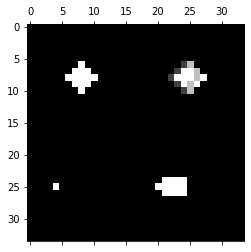

In [31]:
fig, ax = plt.subplots()
mat = ax.matshow(extract_data(cell, target), cmap='gray')
cell, target, i = animate2(i, cell, target, food)
print(cell[:, 0].sum())